# Ground-roll attenuation model with attention. 1D
## Attention branch as regression of noise mask parameters

Raw field seismograms contain noises of various nature. One type of noise is assosiated with ground-roll waves propagation. The model should suppress the ground-roll noise and keep desired signal unchanged.

* [Dataset](#Dataset)
* [Model architecture](#Model-architecture)
* [Training](#Training)
* [Inference](#Inference)
* [Runnig time](#Running-time)
* [Model evaluation](#Model-evaluation)
* [Criticism](#Criticism)
* [Conclusion](#Conclusion)
* [Suggestions for improvements](#Suggestions-for-improvements)

## Dataset

We exploit the Dataset 1 from a list of dataset on ground-roll attenuation. Description of the Dataset 1 is available [here](https://github.com/analysiscenter/SeismicPro/blob/master/datasets/noise_attenuation.ipynb). 10 first seismograms of the train part we keep for model training, the rest ones for testing. 

Required imports:

In [1]:
import sys
sys.path.append('../..')

import warnings
warnings.filterwarnings('ignore')
from tensorflow import logging
logging.set_verbosity(logging.ERROR)

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


from seismicpro.batchflow import Pipeline, V, B, L, I, W

from seismicpro.batchflow.batchflow.models.tf import UNet, VGG7
from seismicpro.batchflow.batchflow.models.tf.nn.activations import h_sigmoid

from seismicpro.src import (SeismicDataset, FieldIndex, TraceIndex, statistics_plot,
                            seismic_plot, spectrum_plot, merge_segy_files)
from seismicpro.models import attention_loss_gauss


from Ground_Roll.src.unet_att2_params import UnetAttParams

%env CUDA_VISIBLE_DEVICES=4

env: CUDA_VISIBLE_DEVICES=4


Index dataset

In [3]:
path_raw = '/notebooks/data/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy'
path_lift = '/notebooks/data/noise_dataset_1/DN02B_SHOTS_LIFT1.sgy'

index = (FieldIndex(name='raw', extra_headers=['offset'], path=path_raw)
         .merge(FieldIndex(name='lift', path=path_lift)))
index.head()

,offset,TraceNumber,TRACE_SEQUENCE_FILE,file_id,TRACE_SEQUENCE_FILE,file_id
,,,raw,raw,lift,lift
FieldRecord,,,,,,
111906,35,1656,1,/notebooks/data/noise_dataset_1/DN02A_LIFT_AMP...,1,/notebooks/data/noise_dataset_1/DN02B_SHOTS_LI...
111906,36,1657,2,/notebooks/data/noise_dataset_1/DN02A_LIFT_AMP...,2,/notebooks/data/noise_dataset_1/DN02B_SHOTS_LI...
111906,78,1655,3,/notebooks/data/noise_dataset_1/DN02A_LIFT_AMP...,3,/notebooks/data/noise_dataset_1/DN02B_SHOTS_LI...
111906,79,1658,4,/notebooks/data/noise_dataset_1/DN02A_LIFT_AMP...,4,/notebooks/data/noise_dataset_1/DN02B_SHOTS_LI...
111906,127,1654,5,/notebooks/data/noise_dataset_1/DN02A_LIFT_AMP...,5,/notebooks/data/noise_dataset_1/DN02B_SHOTS_LI...


Reserve 10 field records for model training:

In [4]:
tindex = TraceIndex(index.create_subset(index.indices[:10]))
train_set = SeismicDataset(tindex)

## Model architecture

Model consists of 2 branches, the first one is U-Net that performs signal filtering, the second one generates attention mask.
Attention branch is a VGG7 with regression head and it learns the beginning and the end of a ground roll area.
Noise mask is calculated as follows: 
```
x = range(seismogram_length)
mask = sigmoid(x - ground_roll_beginning) * sigmoid(ground_roll_end - x)
```

In the head of the entire model the output from U-Net (filtered signal) and raw seismogram are combined using the mask:
`model_out = unet_out * mask + raw * (1-mask)`. Thus the raw seismogram is changed only where grownd roll was detected by attention branch

Loss is calculated using both model output and mask: 
`abs(target - model_output) + balance * mean(mask)`. Both difference between model output and target and mask size are minimized. `balance` is hyper-parameter.


Define the model config and loss function:

In [5]:
model_config = {
    'initial_block/inputs': 'trace_raw',
    'inputs': dict(trace_raw={'shape': (3000, 1)},
                   lift={'name': 'targets', 'shape': (3000, 1)}),
    'loss': (attention_loss_gauss, {'balance': 0.05}),
    'optimizer': ('Adam', {'learning_rate': 0.0001}),
    'common/data_format': 'channels_last',
    'common/main_base_class': UNet,
    'common/att_base_class': VGG7,
    'body': {
        'main': {
            'encoder/blocks': dict(layout='ca ca',
                                   filters=[16, 32, 64, 128],
                                   kernel_size=[7, 5, 5, 5],
                                   activation=tf.nn.elu),
            'encoder/downsample': dict(layout='pd',
                                       pool_size=2,
                                       pool_strides=2,
                                       dropout_rate=0.05),
            'embedding': dict(layout='ca ca', kernel_size=5, filters=256),
            'decoder/blocks': dict(layout='ca ca',
                                   filters=[16, 32, 64, 128][::-1],
                                   kernel_size=[7, 5, 5, 5][::-1],
                                   activation=tf.nn.elu),
            'decoder/upsample': dict(layout='tad',
                                     kernel_size=[7, 5, 5, 5][::-1],
                                     strides=2,
                                     dropout_rate=0.05,
                                     activation=tf.nn.elu, ),
        },
        'att': {},
    },
    'head': {
        'main': dict(layout='c', filters=1, units=1),
        'att': dict(layout='fa', units=2, activation=h_sigmoid),
    },

    'train_steps': {'step_main': {'scope': 'main_branch'},
                 'step_attention': {'scope': 'attention_branch'}}
}

## Training

Training pipeline actions:
* loading a batch of raw and target traces
* model weights update

Optimizer configuration:
* optimizer: Adam
* learning_rate = 0.0001

Loss balance: 0.05

Training scheme:
* ```batch_size``` = 64
* ```n_epochs``` = 2.

Define a train pipeline:

In [6]:
def exp_stack(x):
    return np.expand_dims(np.vstack(x), -1)

def make_data(batch, **kwagrs):
    return {'trace_raw': exp_stack(batch.raw), 'lift': exp_stack(batch.lift)}

train_pipeline = (Pipeline()
                  .init_model('static', UnetAttParams, name='unet', config=model_config)
                  .init_variable('loss', default=list())
                  .load(components=('raw', 'lift'), fmt='segy', tslice=np.arange(3000))
                  .train_model('unet', make_data=make_data, fetches='loss_step_main', save_to=V('loss', 'a'))
                 )

Specify a dataset for model training:

In [7]:
train_pipeline = train_pipeline << train_set

Run model training for 3 epochs with batch size of 64:

In [8]:
batch_size = 64

train_pipeline = train_pipeline.run(batch_size=batch_size, n_epochs=2, drop_last=True,
                                    shuffle=True, bar=True, bar_desc=W(V('loss')[-1].format('Current loss is: {:7.7}')))

Current loss is: 0.01567121: 100%|██████████| 1080/1080 [05:54<00:00,  3.05it/s]


Plot loss function decay:

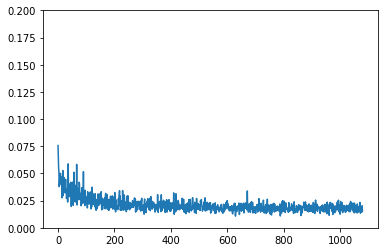

In [9]:
loss = np.array(train_pipeline.get_variable('loss'))
plt.plot(loss)
plt.ylim(0, 0.2)
plt.show()

Calculate average loss during last 100 iterations

In [10]:
from scipy import stats
stats.describe(loss[-100:])

DescribeResult(nobs=100, minmax=(0.012503333, 0.025417063), mean=0.01801513, variance=8.31168e-06, skewness=0.3566897213459015, kurtosis=-0.6159184848273611)

## Test

Here we define a simple test procedure:
`i` is a test field number
* Load the model from training pipeline
* load data from i-th field
* predict outputs for each trace in the field
* save model output and mask
* plot raw seismogram, mask, model output and differences between model output and raw and model output and lift

In [11]:
fetches=['out_lift', 'mask']

test_pipeline = (Pipeline()
                 .import_model('unet', train_pipeline)
                 .init_variable('res', default=list())
                 .init_variable('raw', default=list())
                 .init_variable('lift', default=list())
                 .load(components=('raw', 'lift'), fmt='segy', tslice=np.arange(3000))
                 .update_variable('raw', B('raw'), mode='a')
                 .update_variable('lift', B('lift'), mode='a')
                 .predict_model('unet', make_data=make_data, fetches=fetches, save_to=V('res', 'a')))


def check_res(i, test_pipeline, cv=0.1):  
    test_set = SeismicDataset(TraceIndex(index.create_subset(index.indices[i: i+1])))
    test_pipeline = test_pipeline << test_set
    test_pipeline = test_pipeline.run(batch_size=500, n_epochs=1, drop_last=False,
                                  shuffle=False, bar=True)
    raw = np.vstack([np.vstack(x) for x in test_pipeline.get_variable('raw')])
    lift = np.vstack([np.vstack(x) for x in test_pipeline.get_variable('lift')])
    out = np.squeeze(np.vstack([x[0] for x in test_pipeline.get_variable('res')]))
    att = np.squeeze(np.vstack([x[1] for x in test_pipeline.get_variable('res')]))
    seismic_plot([raw, att, out, out - raw, out -lift],
             figsize=(19, 7), names=['RAW', 'NOISE MASK', 'OUTPUT', 'OUTPUT - RAW', 'out-lift'],
             cmap='gray', vmin=-cv, vmax=cv)
    
    return raw, att, lift, out

Run test pipeline:

100%|██████████| 7/7 [00:07<00:00,  1.03s/it]


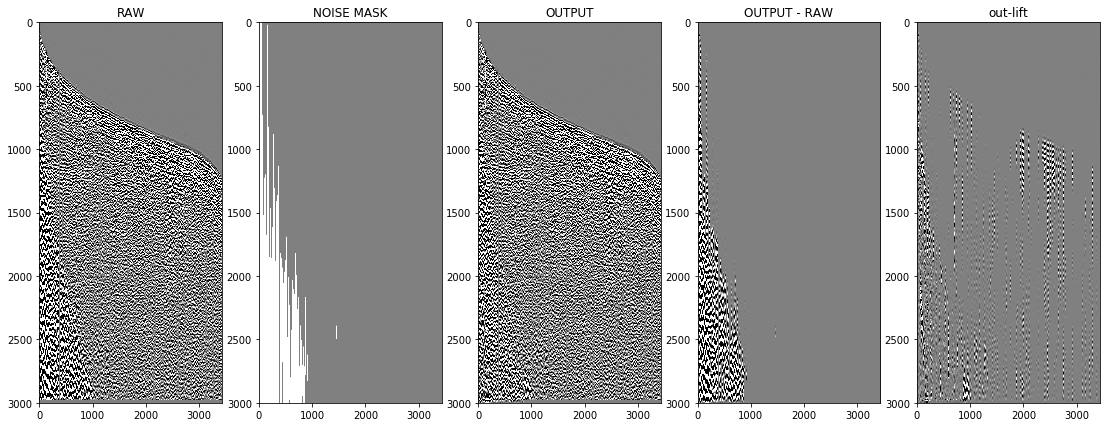

In [12]:
i = 20
raw, att, lift, out = check_res(i, test_pipeline)

We can see that the mask is not detected around first-break area, which is good, but the mask quality still needs improvements

Let's plot single traces.

For trace #500 the mask is a bit underestimated, for its neigbour #501 the mask is too large

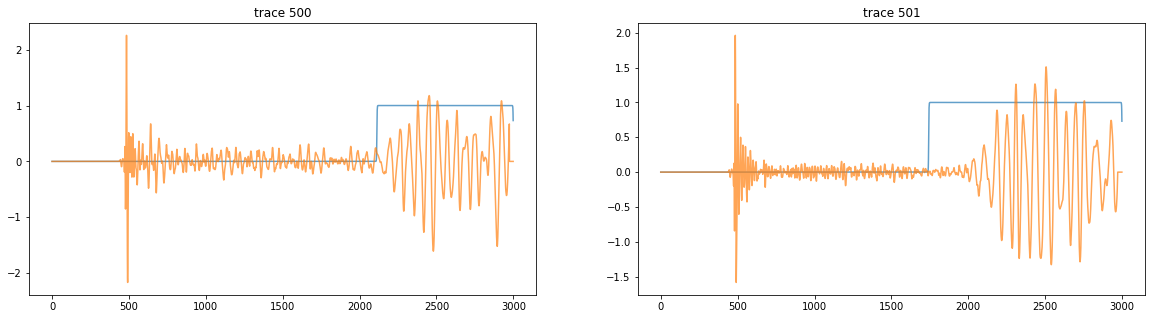

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].plot(np.vstack([att[500], (raw[500])]).T, alpha=0.7);
ax[0].set_title('trace 500');
ax[1].plot(np.vstack([att[501], (raw[501])]).T, alpha=0.7);
ax[1].set_title('trace 501');

For trace 925 no mask is found, for trace 926 wrong mask is found

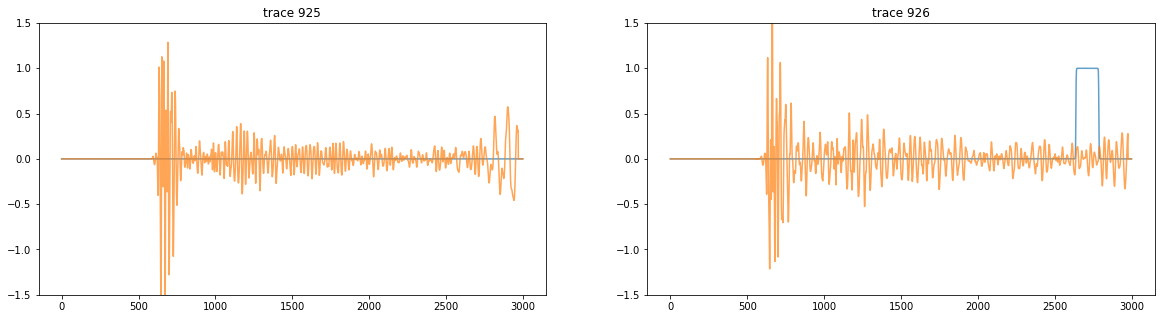

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].plot(np.vstack([att[925], (raw[925])]).T, alpha=0.7);
ax[0].set_ylim(-1.5, 1.5);
ax[0].set_title('trace 925');
ax[1].plot(np.vstack([att[926], (raw[926])]).T, alpha=0.7);
ax[1].set_title('trace 926');
ax[1].set_ylim(-1.5, 1.5);

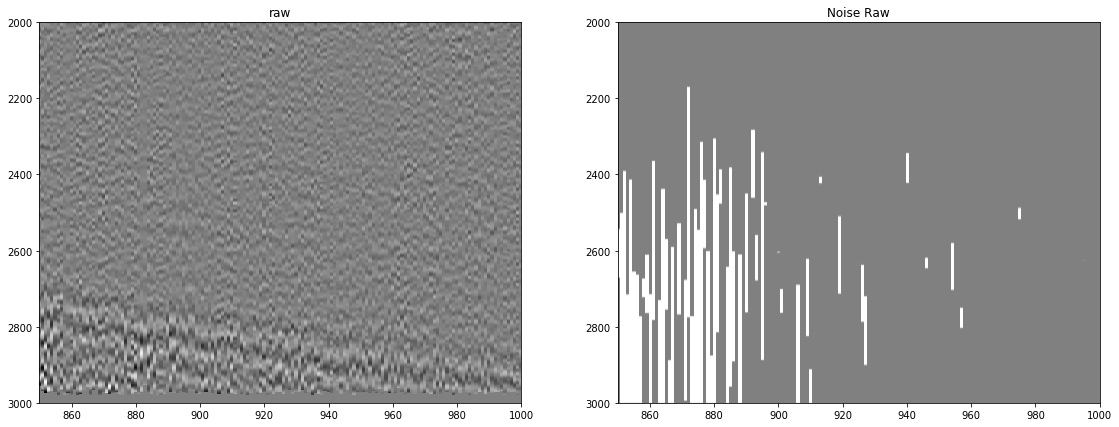

In [48]:
seismic_plot([raw, att], xlim=(850, 1000), ylim=(2000, 3000),
             figsize=(19, 7), names=['raw','Noise Raw', 'NOISE MASK'],
             cmap='gray', vmin=-1, vmax=1)

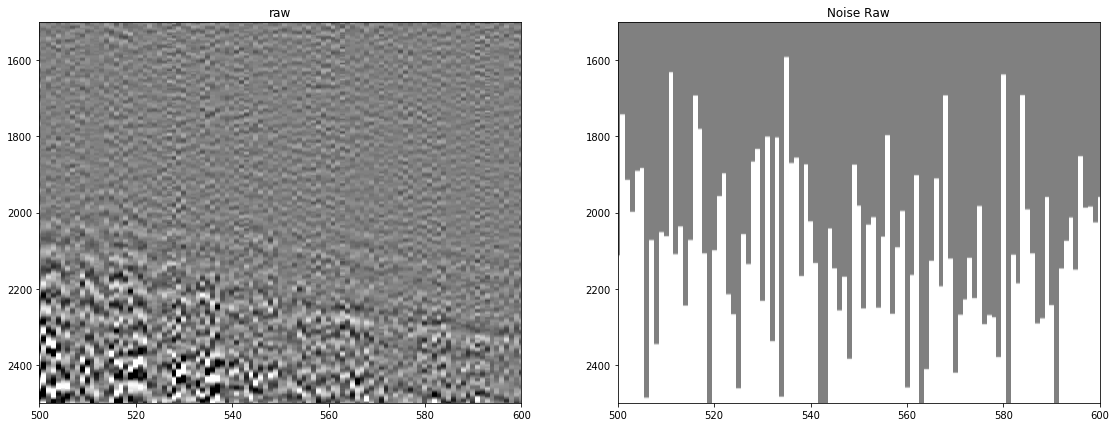

In [26]:
seismic_plot([raw, att], xlim=(500, 600), ylim=(1500, 2500),
             figsize=(19, 7), names=['raw','Noise Raw', 'NOISE MASK'],
             cmap='gray', vmin=-1, vmax=1)

100%|██████████| 7/7 [00:05<00:00,  1.22it/s]


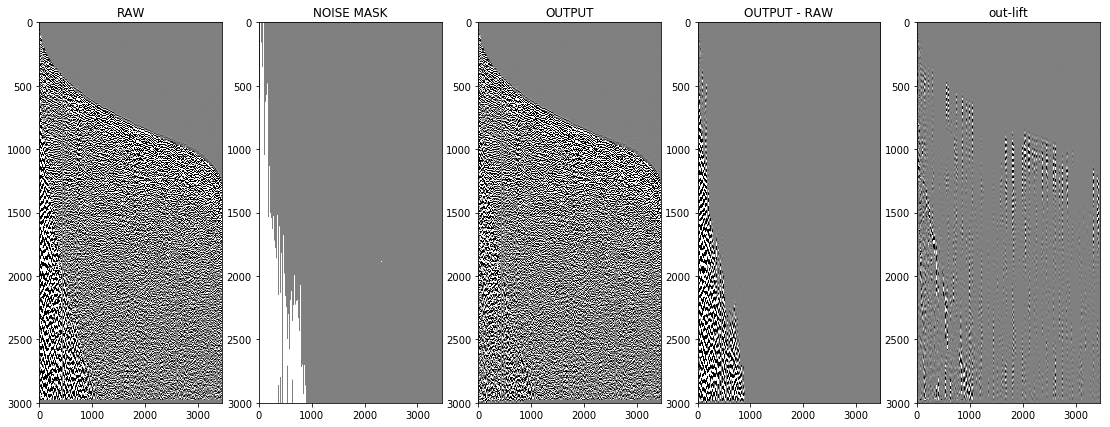

In [25]:
i = 21
check_res(i, test_pipeline);

100%|██████████| 7/7 [00:04<00:00,  1.52it/s]


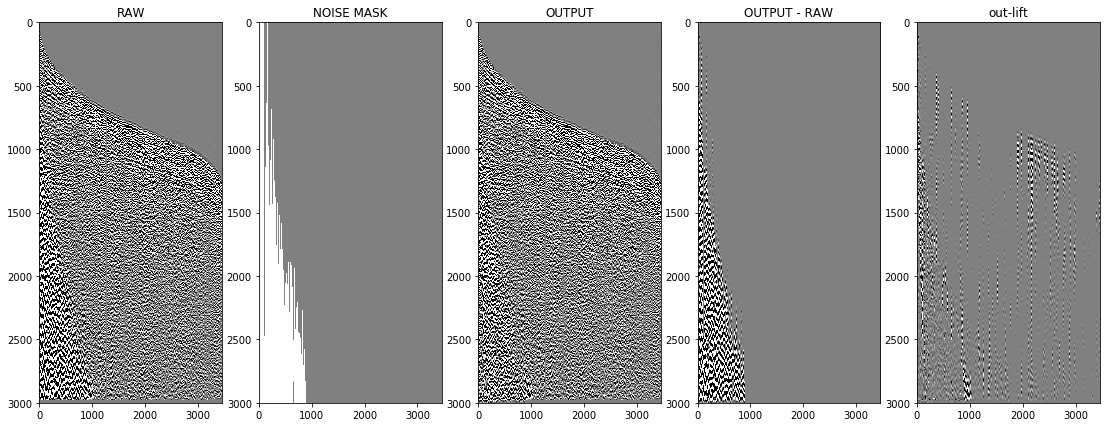

In [51]:
i = 30
check_res(i, test_pipeline);